In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import os
import glob
from typing import Tuple, List, Optional, Dict
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ================================
# Simple U-Net Architecture
# ================================

class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Handle size differences
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels: int = 4, n_classes: int = 4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits

# ================================
# Simple Dataset
# ================================

class SimpleBraTSDataset(Dataset):
    def __init__(self, data_dir: str, image_size: int = 128):
        self.data_dir = data_dir
        self.image_size = image_size
        self.samples = []
        
        # Find all patient directories
        patient_dirs = glob.glob(os.path.join(data_dir, "*"))
        patient_dirs = [d for d in patient_dirs if os.path.isdir(d)]
        
        print(f"Found {len(patient_dirs)} patient directories")
        
        for patient_dir in patient_dirs:
            patient_id = os.path.basename(patient_dir)
            
            # Look for files
            files = {}
            for modality in ['flair', 't1ce', 't1', 't2', 'seg']:
                nii_path = os.path.join(patient_dir, f"{patient_id}_{modality}.nii")
                if os.path.exists(nii_path):
                    files[modality] = nii_path
            
            # Only keep if all files exist
            if len(files) == 5:
                self.samples.append(files)
        
        print(f"Successfully loaded {len(self.samples)} complete samples")
    
    def __len__(self):
        return len(self.samples)
    
    def load_and_preprocess(self, filepath: str, is_mask: bool = False) -> np.ndarray:
        """Simple loading and preprocessing"""
        try:
            # Load NIfTI file
            nii = nib.load(filepath)
            data = nii.get_fdata()
            
            # Take middle slice
            middle_slice = data.shape[2] // 2
            slice_2d = data[:, :, middle_slice]
            
            if is_mask:
                # For mask: convert labels and resize
                mask = np.zeros_like(slice_2d)
                mask[slice_2d == 1] = 1  # necrotic
                mask[slice_2d == 2] = 2  # edema  
                mask[slice_2d == 4] = 3  # enhancing
                slice_2d = cv2.resize(mask.astype(np.uint8), (self.image_size, self.image_size), 
                                    interpolation=cv2.INTER_NEAREST)
            else:
                # For image: normalize and resize
                if slice_2d.max() > 0:
                    slice_2d = slice_2d / slice_2d.max()
                slice_2d = cv2.resize(slice_2d.astype(np.float32), (self.image_size, self.image_size))
            
            return slice_2d
            
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            # Return zeros if loading fails
            if is_mask:
                return np.zeros((self.image_size, self.image_size), dtype=np.uint8)
            else:
                return np.zeros((self.image_size, self.image_size), dtype=np.float32)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load all modalities
        flair = self.load_and_preprocess(sample['flair'])
        t1ce = self.load_and_preprocess(sample['t1ce'])
        t1 = self.load_and_preprocess(sample['t1'])
        t2 = self.load_and_preprocess(sample['t2'])
        mask = self.load_and_preprocess(sample['seg'], is_mask=True)
        
        # Stack channels
        image = np.stack([flair, t1ce, t1, t2], axis=0)  # (4, H, W)
        
        # Convert to tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask

# ================================
# Simple Dice Score
# ================================

def dice_score(pred: torch.Tensor, target: torch.Tensor, smooth: float = 1e-6) -> float:
    """Calculate Dice score"""
    pred = F.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    
    # Calculate dice for each class (excluding background)
    dice_scores = []
    for class_idx in [1, 2, 3]:  # necrotic, edema, enhancing
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()
        
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        
        if union > 0:
            dice = (2 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())
    
    return np.mean(dice_scores) if dice_scores else 0.0

# ================================
# Simple Training Function
# ================================

def train_simple_unet(data_dir: str, epochs: int = 50, batch_size: int = 4, 
                     learning_rate: float = 1e-3, image_size: int = 128):
    """Simple training pipeline"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create dataset
    print("Loading dataset...")
    dataset = SimpleBraTSDataset(data_dir, image_size)
    
    if len(dataset) == 0:
        print("No samples found!")
        return None
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create model
    model = UNet(n_channels=4, n_classes=4).to(device)
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    best_dice = 0
    
    print("Starting training...")
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_dice = 0
        
        for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            with torch.no_grad():
                dice = dice_score(outputs, masks)
                train_dice += dice
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
                dice = dice_score(outputs, masks)
                val_dice += dice
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}')
        
        # Save best model
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            torch.save(model.state_dict(), 'best_simple_model.pth')
            print(f'  New best model saved! Dice: {best_dice:.4f}')
        
        print('-' * 50)
    
    print(f'Training completed! Best Dice: {best_dice:.4f}')
    return model, best_dice

# ================================
# Main Execution
# ================================

if __name__ == "__main__":
    data_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
    
    print("🚀 Starting Simple BraTS2020 U-Net Training")
    print("=" * 60)
    
    try:
        model, best_dice = train_simple_unet(
            data_dir=data_dir,
            epochs=75,
            batch_size=8,
            learning_rate=1e-3,
            image_size=128
        )
        
        if model is not None:
            print(f"🎉 Training successful! Best Dice: {best_dice:.4f}")
        else:
            print("❌ Training failed")
            
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
    
    print("✅ Done!")

🚀 Starting Simple BraTS2020 U-Net Training
Using device: cuda
Loading dataset...
Found 369 patient directories
Successfully loaded 368 complete samples
Train samples: 294, Val samples: 74
Model parameters: 31,391,492
Starting training...


Epoch 1: 100%|██████████| 37/37 [03:25<00:00,  5.56s/it]


Epoch 1/75:
  Train Loss: 0.4871, Train Dice: 0.1663
  Val Loss: 0.3676, Val Dice: 0.1398
  New best model saved! Dice: 0.1398
--------------------------------------------------


Epoch 2: 100%|██████████| 37/37 [02:29<00:00,  4.05s/it]


Epoch 2/75:
  Train Loss: 0.1628, Train Dice: 0.1858
  Val Loss: 0.1510, Val Dice: 0.1833
  New best model saved! Dice: 0.1833
--------------------------------------------------


Epoch 3: 100%|██████████| 37/37 [01:58<00:00,  3.21s/it]


Epoch 3/75:
  Train Loss: 0.1052, Train Dice: 0.1858
  Val Loss: 0.3344, Val Dice: 0.1147
--------------------------------------------------


Epoch 4: 100%|██████████| 37/37 [01:39<00:00,  2.70s/it]


Epoch 4/75:
  Train Loss: 0.0826, Train Dice: 0.2131
  Val Loss: 0.0936, Val Dice: 0.2393
  New best model saved! Dice: 0.2393
--------------------------------------------------


Epoch 5: 100%|██████████| 37/37 [01:15<00:00,  2.03s/it]


Epoch 5/75:
  Train Loss: 0.0728, Train Dice: 0.3008
  Val Loss: 0.0829, Val Dice: 0.2998
  New best model saved! Dice: 0.2998
--------------------------------------------------


Epoch 6: 100%|██████████| 37/37 [01:44<00:00,  2.81s/it]


Epoch 6/75:
  Train Loss: 0.0640, Train Dice: 0.3608
  Val Loss: 0.0702, Val Dice: 0.3046
  New best model saved! Dice: 0.3046
--------------------------------------------------


Epoch 7: 100%|██████████| 37/37 [01:48<00:00,  2.92s/it]


Epoch 7/75:
  Train Loss: 0.0603, Train Dice: 0.3903
  Val Loss: 0.0628, Val Dice: 0.4253
  New best model saved! Dice: 0.4253
--------------------------------------------------


Epoch 8: 100%|██████████| 37/37 [01:39<00:00,  2.70s/it]


Epoch 8/75:
  Train Loss: 0.0555, Train Dice: 0.4509
  Val Loss: 0.0574, Val Dice: 0.4318
  New best model saved! Dice: 0.4318
--------------------------------------------------


Epoch 9: 100%|██████████| 37/37 [01:47<00:00,  2.90s/it]


Epoch 9/75:
  Train Loss: 0.0534, Train Dice: 0.4757
  Val Loss: 0.0610, Val Dice: 0.4477
  New best model saved! Dice: 0.4477
--------------------------------------------------


Epoch 10: 100%|██████████| 37/37 [01:43<00:00,  2.78s/it]


Epoch 10/75:
  Train Loss: 0.0501, Train Dice: 0.4680
  Val Loss: 0.0673, Val Dice: 0.3923
--------------------------------------------------


Epoch 11: 100%|██████████| 37/37 [01:41<00:00,  2.74s/it]


Epoch 11/75:
  Train Loss: 0.0486, Train Dice: 0.4990
  Val Loss: 0.0548, Val Dice: 0.4418
--------------------------------------------------


Epoch 12: 100%|██████████| 37/37 [01:41<00:00,  2.75s/it]


Epoch 12/75:
  Train Loss: 0.0478, Train Dice: 0.4906
  Val Loss: 0.0503, Val Dice: 0.5304
  New best model saved! Dice: 0.5304
--------------------------------------------------


Epoch 13: 100%|██████████| 37/37 [01:44<00:00,  2.82s/it]


Epoch 13/75:
  Train Loss: 0.0460, Train Dice: 0.5232
  Val Loss: 0.0529, Val Dice: 0.5036
--------------------------------------------------


Epoch 14: 100%|██████████| 37/37 [01:39<00:00,  2.70s/it]


Epoch 14/75:
  Train Loss: 0.0445, Train Dice: 0.5176
  Val Loss: 0.0498, Val Dice: 0.5229
--------------------------------------------------


Epoch 15: 100%|██████████| 37/37 [01:45<00:00,  2.85s/it]


Epoch 15/75:
  Train Loss: 0.0445, Train Dice: 0.5439
  Val Loss: 0.0516, Val Dice: 0.5037
--------------------------------------------------


Epoch 16: 100%|██████████| 37/37 [01:46<00:00,  2.87s/it]


Epoch 16/75:
  Train Loss: 0.0437, Train Dice: 0.5427
  Val Loss: 0.0548, Val Dice: 0.3224
--------------------------------------------------


Epoch 17: 100%|██████████| 37/37 [01:31<00:00,  2.48s/it]


Epoch 17/75:
  Train Loss: 0.0420, Train Dice: 0.5424
  Val Loss: 0.0501, Val Dice: 0.4526
--------------------------------------------------


Epoch 18: 100%|██████████| 37/37 [01:43<00:00,  2.80s/it]


Epoch 18/75:
  Train Loss: 0.0381, Train Dice: 0.5860
  Val Loss: 0.0473, Val Dice: 0.5817
  New best model saved! Dice: 0.5817
--------------------------------------------------


Epoch 19: 100%|██████████| 37/37 [01:42<00:00,  2.77s/it]


Epoch 19/75:
  Train Loss: 0.0372, Train Dice: 0.5780
  Val Loss: 0.0414, Val Dice: 0.6107
  New best model saved! Dice: 0.6107
--------------------------------------------------


Epoch 20: 100%|██████████| 37/37 [01:34<00:00,  2.55s/it]


Epoch 20/75:
  Train Loss: 0.0351, Train Dice: 0.6272
  Val Loss: 0.0560, Val Dice: 0.4437
--------------------------------------------------


Epoch 21: 100%|██████████| 37/37 [01:45<00:00,  2.85s/it]


Epoch 21/75:
  Train Loss: 0.0358, Train Dice: 0.6196
  Val Loss: 0.0444, Val Dice: 0.5785
--------------------------------------------------


Epoch 22: 100%|██████████| 37/37 [01:43<00:00,  2.80s/it]


Epoch 22/75:
  Train Loss: 0.0361, Train Dice: 0.6326
  Val Loss: 0.0413, Val Dice: 0.6206
  New best model saved! Dice: 0.6206
--------------------------------------------------


Epoch 23: 100%|██████████| 37/37 [01:39<00:00,  2.68s/it]


Epoch 23/75:
  Train Loss: 0.0351, Train Dice: 0.6441
  Val Loss: 0.0485, Val Dice: 0.5621
--------------------------------------------------


Epoch 24: 100%|██████████| 37/37 [01:43<00:00,  2.79s/it]


Epoch 24/75:
  Train Loss: 0.0333, Train Dice: 0.6525
  Val Loss: 0.0402, Val Dice: 0.6208
  New best model saved! Dice: 0.6208
--------------------------------------------------


Epoch 25: 100%|██████████| 37/37 [01:45<00:00,  2.85s/it]


Epoch 25/75:
  Train Loss: 0.0347, Train Dice: 0.6337
  Val Loss: 0.0400, Val Dice: 0.6312
  New best model saved! Dice: 0.6312
--------------------------------------------------


Epoch 26: 100%|██████████| 37/37 [01:40<00:00,  2.72s/it]


Epoch 26/75:
  Train Loss: 0.0328, Train Dice: 0.6498
  Val Loss: 0.0529, Val Dice: 0.6084
--------------------------------------------------


Epoch 27: 100%|██████████| 37/37 [01:37<00:00,  2.65s/it]


Epoch 27/75:
  Train Loss: 0.0315, Train Dice: 0.6660
  Val Loss: 0.0429, Val Dice: 0.5934
--------------------------------------------------


Epoch 28: 100%|██████████| 37/37 [01:54<00:00,  3.10s/it]


Epoch 28/75:
  Train Loss: 0.0316, Train Dice: 0.6591
  Val Loss: 0.0374, Val Dice: 0.6457
  New best model saved! Dice: 0.6457
--------------------------------------------------


Epoch 29: 100%|██████████| 37/37 [01:50<00:00,  2.97s/it]


Epoch 29/75:
  Train Loss: 0.0337, Train Dice: 0.6566
  Val Loss: 0.0389, Val Dice: 0.6496
  New best model saved! Dice: 0.6496
--------------------------------------------------


Epoch 30: 100%|██████████| 37/37 [01:42<00:00,  2.76s/it]


Epoch 30/75:
  Train Loss: 0.0316, Train Dice: 0.6683
  Val Loss: 0.0487, Val Dice: 0.5710
--------------------------------------------------


Epoch 31: 100%|██████████| 37/37 [01:41<00:00,  2.74s/it]


Epoch 31/75:
  Train Loss: 0.0306, Train Dice: 0.6775
  Val Loss: 0.0450, Val Dice: 0.6335
--------------------------------------------------


Epoch 32: 100%|██████████| 37/37 [01:43<00:00,  2.79s/it]


Epoch 32/75:
  Train Loss: 0.0291, Train Dice: 0.6728
  Val Loss: 0.0447, Val Dice: 0.6486
--------------------------------------------------


Epoch 33: 100%|██████████| 37/37 [01:43<00:00,  2.80s/it]


Epoch 33/75:
  Train Loss: 0.0280, Train Dice: 0.7107
  Val Loss: 0.0380, Val Dice: 0.5952
--------------------------------------------------


Epoch 34: 100%|██████████| 37/37 [01:40<00:00,  2.71s/it]


Epoch 34/75:
  Train Loss: 0.0302, Train Dice: 0.6714
  Val Loss: 0.0509, Val Dice: 0.5409
--------------------------------------------------


Epoch 35: 100%|██████████| 37/37 [01:42<00:00,  2.76s/it]


Epoch 35/75:
  Train Loss: 0.0290, Train Dice: 0.6644
  Val Loss: 0.0464, Val Dice: 0.5764
--------------------------------------------------


Epoch 36: 100%|██████████| 37/37 [01:44<00:00,  2.84s/it]


Epoch 36/75:
  Train Loss: 0.0291, Train Dice: 0.6923
  Val Loss: 0.0418, Val Dice: 0.6086
--------------------------------------------------


Epoch 37: 100%|██████████| 37/37 [01:54<00:00,  3.09s/it]


Epoch 37/75:
  Train Loss: 0.0285, Train Dice: 0.6861
  Val Loss: 0.0415, Val Dice: 0.5204
--------------------------------------------------


Epoch 38: 100%|██████████| 37/37 [01:42<00:00,  2.76s/it]


Epoch 38/75:
  Train Loss: 0.0287, Train Dice: 0.6825
  Val Loss: 0.0354, Val Dice: 0.6214
--------------------------------------------------


Epoch 39: 100%|██████████| 37/37 [01:43<00:00,  2.79s/it]


Epoch 39/75:
  Train Loss: 0.0272, Train Dice: 0.6920
  Val Loss: 0.0340, Val Dice: 0.6841
  New best model saved! Dice: 0.6841
--------------------------------------------------


Epoch 40: 100%|██████████| 37/37 [01:39<00:00,  2.68s/it]


Epoch 40/75:
  Train Loss: 0.0301, Train Dice: 0.6693
  Val Loss: 0.1135, Val Dice: 0.3943
--------------------------------------------------


Epoch 41: 100%|██████████| 37/37 [01:34<00:00,  2.55s/it]


Epoch 41/75:
  Train Loss: 0.0313, Train Dice: 0.6604
  Val Loss: 0.0501, Val Dice: 0.5748
--------------------------------------------------


Epoch 42: 100%|██████████| 37/37 [01:37<00:00,  2.64s/it]


Epoch 42/75:
  Train Loss: 0.0298, Train Dice: 0.6837
  Val Loss: 0.0345, Val Dice: 0.6797
--------------------------------------------------


Epoch 43: 100%|██████████| 37/37 [01:47<00:00,  2.90s/it]


Epoch 43/75:
  Train Loss: 0.0272, Train Dice: 0.7062
  Val Loss: 0.0370, Val Dice: 0.6221
--------------------------------------------------


Epoch 44: 100%|██████████| 37/37 [01:42<00:00,  2.78s/it]


Epoch 44/75:
  Train Loss: 0.0261, Train Dice: 0.7097
  Val Loss: 0.0339, Val Dice: 0.6788
--------------------------------------------------


Epoch 45: 100%|██████████| 37/37 [01:42<00:00,  2.77s/it]


Epoch 45/75:
  Train Loss: 0.0262, Train Dice: 0.7131
  Val Loss: 0.0408, Val Dice: 0.6148
--------------------------------------------------


Epoch 46: 100%|██████████| 37/37 [01:41<00:00,  2.74s/it]


Epoch 46/75:
  Train Loss: 0.0257, Train Dice: 0.7064
  Val Loss: 0.0382, Val Dice: 0.6699
--------------------------------------------------


Epoch 47: 100%|██████████| 37/37 [01:42<00:00,  2.76s/it]


Epoch 47/75:
  Train Loss: 0.0252, Train Dice: 0.7305
  Val Loss: 0.0424, Val Dice: 0.5340
--------------------------------------------------


Epoch 48: 100%|██████████| 37/37 [01:43<00:00,  2.79s/it]


Epoch 48/75:
  Train Loss: 0.0266, Train Dice: 0.7027
  Val Loss: 0.0581, Val Dice: 0.6228
--------------------------------------------------


Epoch 49: 100%|██████████| 37/37 [01:54<00:00,  3.09s/it]


Epoch 49/75:
  Train Loss: 0.0274, Train Dice: 0.7108
  Val Loss: 0.0427, Val Dice: 0.5985
--------------------------------------------------


Epoch 50: 100%|██████████| 37/37 [01:41<00:00,  2.73s/it]


Epoch 50/75:
  Train Loss: 0.0256, Train Dice: 0.7292
  Val Loss: 0.0396, Val Dice: 0.6709
--------------------------------------------------


Epoch 51: 100%|██████████| 37/37 [01:37<00:00,  2.63s/it]


Epoch 51/75:
  Train Loss: 0.0241, Train Dice: 0.7340
  Val Loss: 0.0384, Val Dice: 0.6228
--------------------------------------------------


Epoch 52: 100%|██████████| 37/37 [01:44<00:00,  2.82s/it]


Epoch 52/75:
  Train Loss: 0.0239, Train Dice: 0.7378
  Val Loss: 0.0362, Val Dice: 0.6498
--------------------------------------------------


Epoch 53: 100%|██████████| 37/37 [01:42<00:00,  2.76s/it]


Epoch 53/75:
  Train Loss: 0.0255, Train Dice: 0.7327
  Val Loss: 0.0466, Val Dice: 0.5689
--------------------------------------------------


Epoch 54: 100%|██████████| 37/37 [01:38<00:00,  2.65s/it]


Epoch 54/75:
  Train Loss: 0.0246, Train Dice: 0.7319
  Val Loss: 0.0369, Val Dice: 0.6271
--------------------------------------------------


Epoch 55: 100%|██████████| 37/37 [01:45<00:00,  2.86s/it]


Epoch 55/75:
  Train Loss: 0.0226, Train Dice: 0.7600
  Val Loss: 0.0330, Val Dice: 0.6949
  New best model saved! Dice: 0.6949
--------------------------------------------------


Epoch 56: 100%|██████████| 37/37 [01:37<00:00,  2.62s/it]


Epoch 56/75:
  Train Loss: 0.0216, Train Dice: 0.7600
  Val Loss: 0.0427, Val Dice: 0.6263
--------------------------------------------------


Epoch 57: 100%|██████████| 37/37 [01:39<00:00,  2.68s/it]


Epoch 57/75:
  Train Loss: 0.0236, Train Dice: 0.7432
  Val Loss: 0.0393, Val Dice: 0.6476
--------------------------------------------------


Epoch 58: 100%|██████████| 37/37 [01:41<00:00,  2.74s/it]


Epoch 58/75:
  Train Loss: 0.0235, Train Dice: 0.7371
  Val Loss: 0.0352, Val Dice: 0.6695
--------------------------------------------------


Epoch 59: 100%|██████████| 37/37 [01:38<00:00,  2.67s/it]


Epoch 59/75:
  Train Loss: 0.0231, Train Dice: 0.7339
  Val Loss: 0.0438, Val Dice: 0.6194
--------------------------------------------------


Epoch 60: 100%|██████████| 37/37 [01:37<00:00,  2.63s/it]


Epoch 60/75:
  Train Loss: 0.0220, Train Dice: 0.7501
  Val Loss: 0.0405, Val Dice: 0.6264
--------------------------------------------------


Epoch 61: 100%|██████████| 37/37 [01:41<00:00,  2.74s/it]


Epoch 61/75:
  Train Loss: 0.0222, Train Dice: 0.7576
  Val Loss: 0.0394, Val Dice: 0.5996
--------------------------------------------------


Epoch 62: 100%|██████████| 37/37 [01:37<00:00,  2.65s/it]


Epoch 62/75:
  Train Loss: 0.0240, Train Dice: 0.7407
  Val Loss: 0.0383, Val Dice: 0.5878
--------------------------------------------------


Epoch 63: 100%|██████████| 37/37 [01:47<00:00,  2.90s/it]


Epoch 63/75:
  Train Loss: 0.0235, Train Dice: 0.7508
  Val Loss: 0.0331, Val Dice: 0.6528
--------------------------------------------------


Epoch 64: 100%|██████████| 37/37 [01:47<00:00,  2.91s/it]


Epoch 64/75:
  Train Loss: 0.0211, Train Dice: 0.7865
  Val Loss: 0.0408, Val Dice: 0.6774
--------------------------------------------------


Epoch 65: 100%|██████████| 37/37 [01:40<00:00,  2.72s/it]


Epoch 65/75:
  Train Loss: 0.0214, Train Dice: 0.7699
  Val Loss: 0.0372, Val Dice: 0.7009
  New best model saved! Dice: 0.7009
--------------------------------------------------


Epoch 66: 100%|██████████| 37/37 [01:43<00:00,  2.79s/it]


Epoch 66/75:
  Train Loss: 0.0202, Train Dice: 0.7566
  Val Loss: 0.0355, Val Dice: 0.6932
--------------------------------------------------


Epoch 67: 100%|██████████| 37/37 [01:43<00:00,  2.79s/it]


Epoch 67/75:
  Train Loss: 0.0216, Train Dice: 0.7707
  Val Loss: 0.0544, Val Dice: 0.6116
--------------------------------------------------


Epoch 68: 100%|██████████| 37/37 [01:37<00:00,  2.64s/it]


Epoch 68/75:
  Train Loss: 0.0204, Train Dice: 0.7785
  Val Loss: 0.0365, Val Dice: 0.6768
--------------------------------------------------


Epoch 69: 100%|██████████| 37/37 [01:39<00:00,  2.68s/it]


Epoch 69/75:
  Train Loss: 0.0204, Train Dice: 0.7662
  Val Loss: 0.0366, Val Dice: 0.7069
  New best model saved! Dice: 0.7069
--------------------------------------------------


Epoch 70: 100%|██████████| 37/37 [01:44<00:00,  2.83s/it]


Epoch 70/75:
  Train Loss: 0.0183, Train Dice: 0.8007
  Val Loss: 0.0391, Val Dice: 0.6654
--------------------------------------------------


Epoch 71: 100%|██████████| 37/37 [01:37<00:00,  2.64s/it]


Epoch 71/75:
  Train Loss: 0.0197, Train Dice: 0.7860
  Val Loss: 0.0339, Val Dice: 0.6984
--------------------------------------------------


Epoch 72: 100%|██████████| 37/37 [01:42<00:00,  2.77s/it]


Epoch 72/75:
  Train Loss: 0.0192, Train Dice: 0.7958
  Val Loss: 0.0415, Val Dice: 0.6267
--------------------------------------------------


Epoch 73: 100%|██████████| 37/37 [01:40<00:00,  2.72s/it]


Epoch 73/75:
  Train Loss: 0.0212, Train Dice: 0.7660
  Val Loss: 0.0451, Val Dice: 0.6221
--------------------------------------------------


Epoch 74: 100%|██████████| 37/37 [01:42<00:00,  2.77s/it]


Epoch 74/75:
  Train Loss: 0.0193, Train Dice: 0.7959
  Val Loss: 0.0341, Val Dice: 0.6856
--------------------------------------------------


Epoch 75: 100%|██████████| 37/37 [01:47<00:00,  2.91s/it]


Epoch 75/75:
  Train Loss: 0.0190, Train Dice: 0.7859
  Val Loss: 0.0403, Val Dice: 0.6486
--------------------------------------------------
Training completed! Best Dice: 0.7069
🎉 Training successful! Best Dice: 0.7069
✅ Done!


Found 369 patient directories
Successfully loaded 368 complete samples


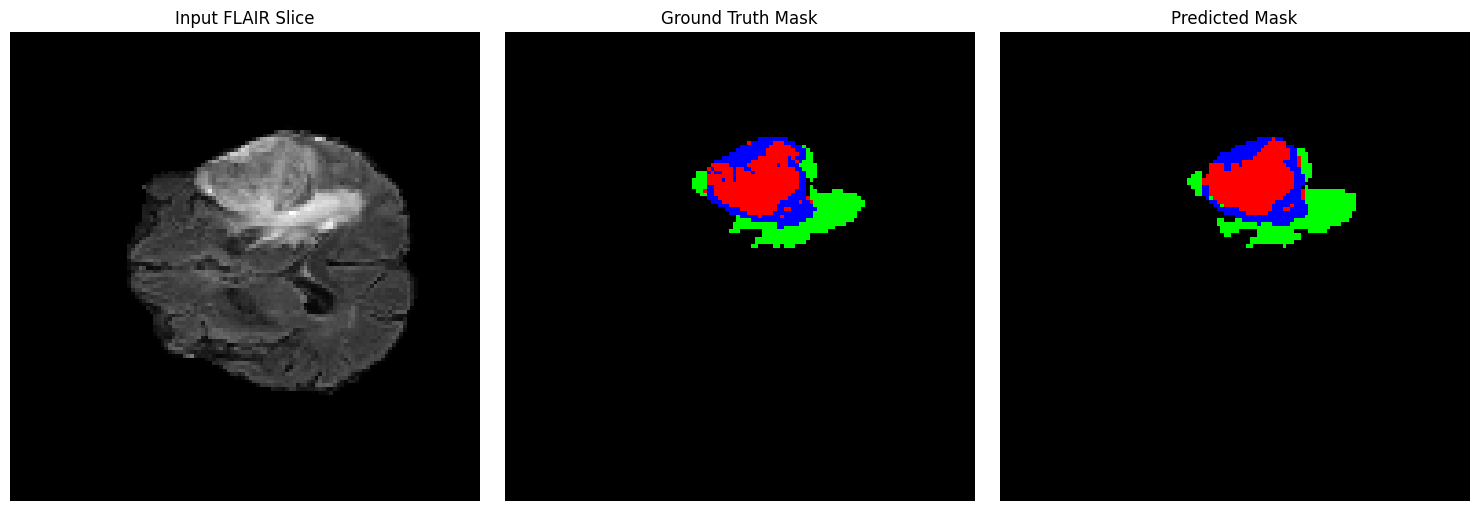

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Label map (class index to name/color)
label_map = {
    0: (0, 0, 0),        # background
    1: (255, 0, 0),      # necrotic core (red)
    2: (0, 255, 0),      # edema (green)
    3: (0, 0, 255),      # enhancing tumor (blue)
}

def decode_segmap(mask, num_classes=4):
    """Convert label mask to RGB image for visualization"""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in label_map.items():
        rgb[mask == class_idx] = color
    return rgb

def visualize_prediction(model, dataset, index=0, device='cuda'):
    """Visualize input, ground truth, and prediction"""
    model.eval()
    
    image, true_mask = dataset[index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    true_mask_np = true_mask.numpy()

    with torch.no_grad():
        output = model(image)
        pred_mask = torch.argmax(F.softmax(output, dim=1), dim=1).squeeze(0).cpu().numpy()

    # Choose one modality to visualize (e.g., FLAIR = channel 0)
    flair_image = image.squeeze(0)[0].cpu().numpy()

    # Convert masks to RGB
    true_mask_rgb = decode_segmap(true_mask_np)
    pred_mask_rgb = decode_segmap(pred_mask)

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(flair_image, cmap='gray')
    plt.title("Input FLAIR Slice")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_rgb)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_rgb)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Redefine device (same as used during training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reload dataset for visualization (you already defined this class earlier)
dataset = SimpleBraTSDataset(data_dir="/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData", image_size=128)

# Load best model weights (if saved)
model.load_state_dict(torch.load('best_simple_model.pth', map_location=device))
model.to(device)

# Visualize prediction
visualize_prediction(model, dataset, index=10, device=device)



In [11]:
from torchinfo import summary

# Instantiate model
model = UNet(n_channels=4, n_classes=4).to('cuda' if torch.cuda.is_available() else 'cpu')

# Print summary
summary(model, input_size=(1, 4, 128, 128))


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 4, 128, 128]          --
├─DoubleConv: 1-1                             [1, 64, 128, 128]         --
│    └─Sequential: 2-1                        [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                       [1, 64, 128, 128]         2,368
│    │    └─BatchNorm2d: 3-2                  [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                         [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                       [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5                  [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                         [1, 64, 128, 128]         --
├─Down: 1-2                                   [1, 128, 64, 64]          --
│    └─Sequential: 2-2                        [1, 128, 64, 64]          --
│    │    └─MaxPool2d: 3-7                    [1, 64, 64, 64]           --
│    │    └